In [ ]:
import os
import csv
import re
from bs4 import BeautifulSoup
import justext
import trafilatura
from readability import Document
from rouge_score import rouge_scorer
import requests 
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
from collections import Counter
import math
import time

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

ROOT_DIR = "data/website-data"
SCORE_FILE = "evaluations/enhanced_qualitative_scores.csv"
METHODS = ['jusText', 'Trafilatura', 'Readability', 'Baseline', 'Ollama']

# Initialize scorers
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothing = SmoothingFunction().method1

# --- Extraction methods ---
def extract_justext(html):
    paragraphs = justext.justext(html, justext.get_stoplist("German"))
    return ' '.join(p.text for p in paragraphs if not p.is_boilerplate)

def extract_trafilatura(html):
    result = trafilatura.extract(html)
    return result if result else ""

def extract_readability(html):
    doc = Document(html)
    summary_html = doc.summary()
    return BeautifulSoup(summary_html, "html.parser").get_text()

def extract_baseline(html):
    soup = BeautifulSoup(html, 'html.parser')
    title = soup.title.string if soup.title else ''
    paragraphs = ' '.join(p.get_text() for p in soup.find_all('p'))
    return title + ' ' + paragraphs

def extract_ollama(html, max_retries=10, delay_seconds=5):
    """
    Attempt to extract content using Ollama with retries.
    """
    prompt_template = (
        "You are an expert at extracting clean and relevant content from HTML pages. "
        "Given the following HTML document, extract only the main article or business description text. "
        "Ignore boilerplate such as navigation menus, footers, ads, links, and legal disclaimers.\n\n"
        "HTML:\n"
        f"{html[:5000]}"
    )

    for attempt in range(1, max_retries + 1):
        try:
            response = requests.post(
                "http://localhost:11434/api/generate",
                json={
                    "model": "llama3.2:latest",
                    "prompt": prompt_template,
                    "stream": False
                },
                timeout=30
            )

            if response.status_code == 200:
                result = response.json()
                content = result.get("response", "").strip()
                if content:
                    return content
            print(f"⚠️ Attempt {attempt}: Ollama response was empty or failed with status {response.status_code}")
        except requests.exceptions.ConnectionError:
            print(f"⚠️ Attempt {attempt}: Ollama server is not running.")
        except Exception as e:
            print(f"⚠️ Attempt {attempt}: Ollama failed with exception: {e}")
        
        if attempt < max_retries:
            print(f"🔁 Retrying in {delay_seconds} seconds...")
            time.sleep(delay_seconds)

    print("❌ Ollama extraction failed after maximum retries.")
    return ""

# --- Enhanced evaluation metrics ---

def calculate_rouge_scores(reference, candidate):
    """Calculate ROUGE-1, ROUGE-2, and ROUGE-L scores"""
    if not candidate or not reference:
        return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}
    
    scores = rouge_scorer_obj.score(reference, candidate)
    return {
        'rouge1': scores['rouge1'].fmeasure,
        'rouge2': scores['rouge2'].fmeasure, 
        'rougeL': scores['rougeL'].fmeasure
    }


def calculate_precision_recall_f1(reference, candidate):
    """Calculate precision, recall, and F1 score based on word overlap"""
    if not candidate or not reference:
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    
    ref_words = set(word_tokenize(reference.lower()))
    cand_words = set(word_tokenize(candidate.lower()))
    
    if not cand_words:
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    
    intersection = ref_words.intersection(cand_words)
    
    precision = len(intersection) / len(cand_words) if cand_words else 0.0
    recall = len(intersection) / len(ref_words) if ref_words else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {'precision': precision, 'recall': recall, 'f1': f1}

def calculate_content_noise_ratio(text, html_content=None):
    """
    Enhanced content-to-noise ratio calculation
    Considers multiple noise indicators
    """
    if not text:
        return 0.0
    
    total_words = len(text.split())
    if total_words == 0:
        return 0.0
    
    # Noise indicators
    noise_patterns = [
        r'\b(impressum|kontakt|agb|datenschutz|privacy|cookie|terms)\b',  # Legal terms
        r'\b(href=|www\.|http|@|\.(com|de|org))\b',  # URLs and links
        r'\b(navigation|menu|footer|header|sidebar)\b',  # Layout elements
        r'\b(advertisement|ads|banner|sponsored)\b',  # Ads
        r'\b(login|register|subscribe|newsletter)\b',  # User actions
        r'\b(share|like|tweet|facebook|twitter)\b',  # Social media
        r'\b(copyright|©|®|™)\b',  # Copyright symbols
    ]
    
    noise_count = 0
    for pattern in noise_patterns:
        noise_count += len(re.findall(pattern, text.lower()))
    
    # Additional structural noise indicators
    repeated_chars = len(re.findall(r'(.)\1{3,}', text))  # Repeated characters
    excessive_punctuation = len(re.findall(r'[!?]{2,}|\.{3,}', text))  # Multiple punctuation
    
    total_noise = noise_count + repeated_chars + excessive_punctuation
    
    # Content-to-noise ratio (higher is better)
    content_ratio = max(0.0, 1.0 - (total_noise / total_words))
    return content_ratio

def calculate_semantic_coherence(text):
    """
    Calculate semantic coherence based on sentence structure and vocabulary diversity
    """
    if not text:
        return 0.0
    
    try:
        sentences = sent_tokenize(text)
        if len(sentences) < 2:
            return 0.5  # Neutral score for single sentences
        
        words = word_tokenize(text.lower())
        if len(words) < 10:
            return 0.3  # Low score for very short texts
        
        # Vocabulary diversity (Type-Token Ratio)
        unique_words = len(set(words))
        ttr = unique_words / len(words)
        
        # Average sentence length (indicator of complexity)
        avg_sentence_length = len(words) / len(sentences)
        
        # Normalize scores
        ttr_score = min(ttr * 2, 1.0)  # Scale TTR
        length_score = min(avg_sentence_length / 20, 1.0)  # Normalize to reasonable range
        
        # Combined coherence score
        coherence = (ttr_score + length_score) / 2
        return coherence
        
    except:
        return 0.0

def calculate_comprehensive_scores(reference, candidate, method, company):
    """Calculate all evaluation metrics"""
    if not candidate:
        candidate = ""
    if not reference:
        reference = ""
    
    # ROUGE scores
    rouge_scores = calculate_rouge_scores(reference, candidate)
    
    
    
    # Precision, Recall, F1
    prf_scores = calculate_precision_recall_f1(reference, candidate)
    
    # Content-to-noise ratio
    noise_ratio = calculate_content_noise_ratio(candidate)
    
    # Semantic coherence
    coherence = calculate_semantic_coherence(candidate)
    
    # Convert to 0-5 scale for consistency
    def to_score_scale(x, scale=5):
        return round(x * scale, 3)
    
    metrics = {
        'rouge1': to_score_scale(rouge_scores['rouge1']),
        'rouge2': to_score_scale(rouge_scores['rouge2']),
        'rougeL': to_score_scale(rouge_scores['rougeL']),
        'precision': to_score_scale(prf_scores['precision']),
        'recall': to_score_scale(prf_scores['recall']),
        'f1_score': to_score_scale(prf_scores['f1']),
        'content_noise_ratio': to_score_scale(noise_ratio),
        'semantic_coherence': to_score_scale(coherence)
    }
    
    print(f"[{company} - {method}] ROUGE-L={metrics['rougeL']:.2f}, "f" F1={metrics['f1_score']:.2f}, "f"Noise={metrics['content_noise_ratio']:.2f}")
    
    return metrics

# --- File handling functions ---
def get_html_txt_pairs(folder_path):
    files = os.listdir(folder_path)
    html_files = {os.path.splitext(f)[0]: f for f in files if f.endswith(".html")}
    txt_files = {os.path.splitext(f)[0]: f for f in files if f.endswith(".txt")}
    common_keys = set(html_files.keys()).intersection(txt_files.keys())
    return [(html_files[k], txt_files[k], k) for k in common_keys]

def load_pair(folder_path, html_file, txt_file):
    with open(os.path.join(folder_path, html_file), 'r', encoding='utf-8') as f:
        html = f.read()
    with open(os.path.join(folder_path, txt_file), 'r', encoding='utf-8') as f:
        reference = f.read()
    return html, reference.strip().replace('\n', ' ')

def save_enhanced_scores(company, method, metrics):
    """Save comprehensive evaluation scores to CSV"""
    os.makedirs("evaluations", exist_ok=True)
    
    header = ['Company', 'Method', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L',  
              'Precision', 'Recall', 'F1-Score', 'Content-Noise-Ratio', 'Semantic-Coherence']
    
    file_exists = os.path.isfile(SCORE_FILE)
    
    with open(SCORE_FILE, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(header)
        
        row = [company, method,
               metrics['rouge1'], metrics['rouge2'], metrics['rougeL'],
               metrics['precision'], metrics['recall'],
               metrics['f1_score'], metrics['content_noise_ratio'], 
               metrics['semantic_coherence']]
        writer.writerow(row)

# --- Main execution function ---
def run_comprehensive_evaluation():
    """Run evaluation with enhanced metrics on all data pairs"""
    folders = [d for d in os.listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, d))]
    
    print("Starting comprehensive content extraction evaluation...")
    print(f"Using  metrics: ROUGE,  Precision/Recall/F1, Content-Noise Ratio, Semantic Coherence")
    


    for folder in folders:
        folder_path = os.path.join(ROOT_DIR, folder)
        try:
            pairs = get_html_txt_pairs(folder_path)
            print(f"\nProcessing folder: {folder} ({len(pairs)} pairs)")

            for html_file, txt_file, base_name in pairs:
            

                html, reference = load_pair(folder_path, html_file, txt_file)

                # Extract content using all methods
                extraction_results = {
                    'jusText': extract_justext(html),
                    'Trafilatura': extract_trafilatura(html),
                    'Readability': extract_readability(html),
                    'Baseline': extract_baseline(html),
                    'Ollama': extract_ollama(html),
                }

                # Evaluate each method
                for method in METHODS:
                    result = extraction_results[method]
                    if result is None:
                        result = ""

                    metrics = calculate_comprehensive_scores(reference, result, method, base_name)
                    save_enhanced_scores(base_name, method, metrics)

                print(f"Completed evaluation for {base_name}")


        except Exception as e:
            print(f"Error processing folder {folder}: {e}")
    
    print(f"\n Evaluation complete! Results saved to: {SCORE_FILE}")
   

# --- Execution ---
if __name__ == "__main__":
    run_comprehensive_evaluation()

🚀 Starting comprehensive content extraction evaluation...
📊 Using  metrics: ROUGE,  Precision/Recall/F1, Content-Noise Ratio, Semantic Coherence

📂 Processing folder: 2010036432_pflegeheim-mieste-de (14 pairs)
[impressum - jusText] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[impressum - Trafilatura] ROUGE-L=4.38,   F1=4.33, Noise=3.87
[impressum - Readability] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[impressum - Baseline] ROUGE-L=4.08,   F1=3.82, Noise=3.60
[impressum - Ollama] ROUGE-L=1.66,   F1=2.17, Noise=4.54
Completed evaluation for impressum
[unternehmen-jobs - jusText] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[unternehmen-jobs - Trafilatura] ROUGE-L=4.72,   F1=4.66, Noise=5.00
[unternehmen-jobs - Readability] ROUGE-L=4.72,   F1=4.66, Noise=5.00
[unternehmen-jobs - Baseline] ROUGE-L=4.48,   F1=4.50, Noise=5.00
[unternehmen-jobs - Ollama] ROUGE-L=0.08,   F1=0.34, Noise=5.00
Completed evaluation for unternehmen-jobs
[unternehmen - jusText] ROUGE-L=4.70,   F1=4.65, Noise=5.00
[unternehmen - Trafila

[_ - jusText] ROUGE-L=4.49,   F1=4.43, Noise=5.00
[_ - Trafilatura] ROUGE-L=4.60,   F1=4.53, Noise=5.00
[_ - Readability] ROUGE-L=4.49,   F1=4.43, Noise=5.00
[_ - Baseline] ROUGE-L=4.44,   F1=4.43, Noise=5.00
[_ - Ollama] ROUGE-L=2.86,   F1=3.16, Noise=5.00
Completed evaluation for _
[pflege-preise - jusText] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[pflege-preise - Trafilatura] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[pflege-preise - Readability] ROUGE-L=3.00,   F1=3.00, Noise=5.00
[pflege-preise - Baseline] ROUGE-L=2.71,   F1=3.00, Noise=5.00
[pflege-preise - Ollama] ROUGE-L=1.47,   F1=1.60, Noise=4.80
Completed evaluation for pflege-preise
[anmeldung - jusText] ROUGE-L=3.48,   F1=3.56, Noise=4.81
[anmeldung - Trafilatura] ROUGE-L=4.26,   F1=4.37, Noise=4.70
[anmeldung - Readability] ROUGE-L=4.45,   F1=4.45, Noise=4.72
[anmeldung - Baseline] ROUGE-L=4.29,   F1=4.33, Noise=4.70
[anmeldung - Ollama] ROUGE-L=1.95,   F1=2.16, Noise=4.92
Completed evaluation for anmeldung
[pflege - jusText] ROUGE-

ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


[2023-12-01-unsere-spende-fuer-die-drk - jusText] ROUGE-L=3.96,   F1=3.91, Noise=5.00
[2023-12-01-unsere-spende-fuer-die-drk - Trafilatura] ROUGE-L=3.52,   F1=3.94, Noise=5.00
[2023-12-01-unsere-spende-fuer-die-drk - Readability] ROUGE-L=0.30,   F1=0.65, Noise=4.87
[2023-12-01-unsere-spende-fuer-die-drk - Baseline] ROUGE-L=4.17,   F1=4.22, Noise=4.79
[2023-12-01-unsere-spende-fuer-die-drk - Ollama] ROUGE-L=0.06,   F1=0.24, Noise=4.41
Completed evaluation for 2023-12-01-unsere-spende-fuer-die-drk

📂 Processing folder: 2011447283_sie-media-de (1 pairs)
[_ - jusText] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[_ - Trafilatura] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[_ - Readability] ROUGE-L=5.00,   F1=5.00, Noise=4.42
[_ - Baseline] ROUGE-L=4.44,   F1=4.70, Noise=4.38
[_ - Ollama] ROUGE-L=2.95,   F1=3.11, Noise=4.82
Completed evaluation for _

📂 Processing folder: 2011583639_liske-de (18 pairs)
[kontakt - jusText] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[kontakt - Trafilatura] ROUGE-L=2.10,   F1=2.56, 

[_ - jusText] ROUGE-L=4.19,   F1=4.21, Noise=4.97
[_ - Trafilatura] ROUGE-L=4.29,   F1=4.28, Noise=5.00
[_ - Readability] ROUGE-L=0.87,   F1=1.24, Noise=4.84
[_ - Baseline] ROUGE-L=2.90,   F1=3.21, Noise=4.71
[_ - Ollama] ROUGE-L=1.17,   F1=1.35, Noise=5.00
Completed evaluation for _

📂 Processing folder: 2011937398_ascaniahotel-de (4 pairs)
[angebote-php - jusText] ROUGE-L=3.98,   F1=3.90, Noise=5.00
[angebote-php - Trafilatura] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[angebote-php - Readability] ROUGE-L=2.14,   F1=2.50, Noise=4.47
[angebote-php - Baseline] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[angebote-php - Ollama] ROUGE-L=0.00,   F1=0.18, Noise=4.90
Completed evaluation for angebote-php


[impressum-htm - jusText] ROUGE-L=2.73,   F1=2.85, Noise=5.00
[impressum-htm - Trafilatura] ROUGE-L=4.03,   F1=4.22, Noise=4.93
[impressum-htm - Readability] ROUGE-L=4.03,   F1=4.25, Noise=4.21
[impressum-htm - Baseline] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[impressum-htm - Ollama] ROUGE-L=0.23,   F1=0.36, Noise=4.93
Completed evaluation for impressum-htm
[_ - jusText] ROUGE-L=3.98,   F1=3.90, Noise=5.00
[_ - Trafilatura] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[_ - Readability] ROUGE-L=2.14,   F1=2.50, Noise=4.47
[_ - Baseline] ROUGE-L=0.00,   F1=0.00, Noise=0.00
[_ - Ollama] ROUGE-L=0.00,   F1=0.12, Noise=4.97
Completed evaluation for _

🔚 Reached limit of 200 successfully processed files. Stopping...

 Evaluation complete! Results saved to: evaluations/enhanced_qualitative_scores.csv


Enhanced Content Extraction Evaluation Analysis
✓ Loaded dataset: 32119 rows, 11 columns
  Methods found: ['Baseline', 'Ollama', 'Readability', 'Trafilatura', 'jusText']

Generating visualizations in 'figures'...
✓ Saved boxplot for ROUGE-L to: figures\boxplot_ROUGE_L.png
✓ Saved boxplot for F1-Score to: figures\boxplot_F1_Score.png
✓ Saved boxplot for Content-Noise-Ratio to: figures\boxplot_Content_Noise_Ratio.png
✓ Saved boxplot for Semantic-Coherence to: figures\boxplot_Semantic_Coherence.png


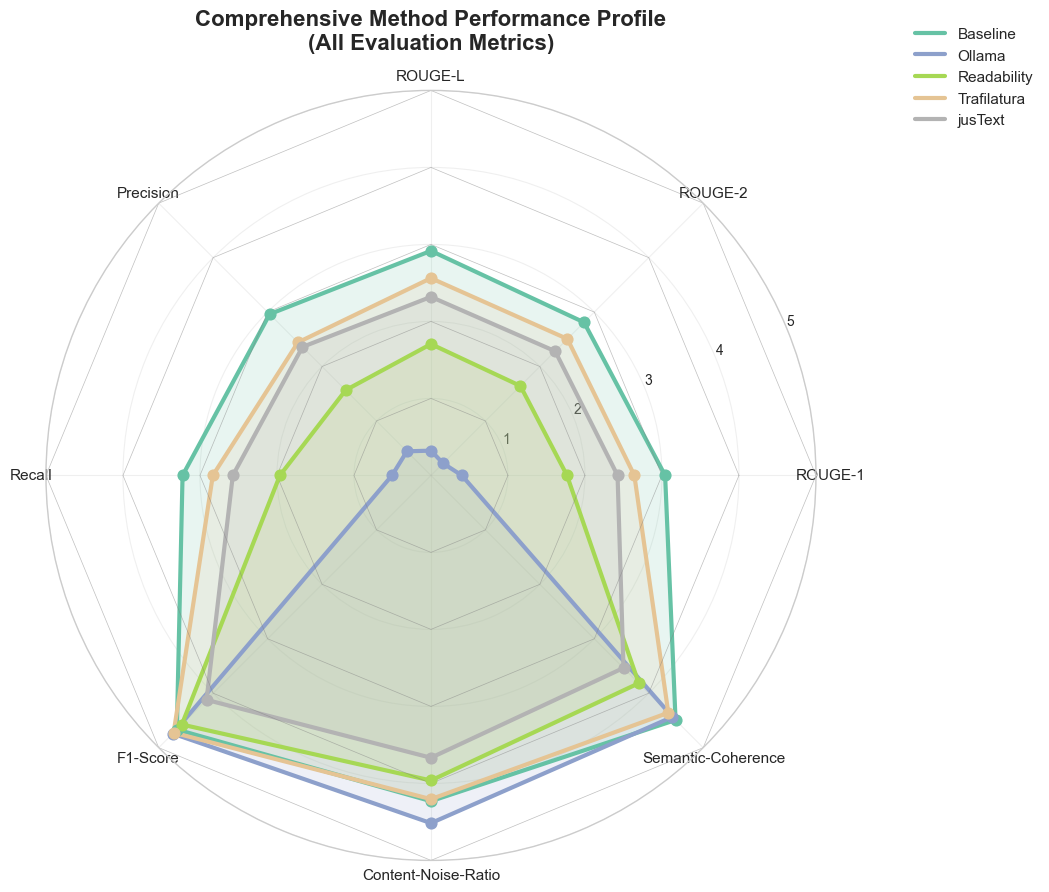

✓ Radar chart saved: figures\radar_chart_comprehensive.png

METHOD RANKING ANALYSIS

Mean Performance Scores (0-5 scale):
             ROUGE-1  ROUGE-2  ROUGE-L  Precision  Recall  F1-Score  Content-Noise-Ratio  Semantic-Coherence
Method                                                                                                      
Baseline       3.041    2.811    2.916      2.962   3.226     4.667                4.231               4.492
Ollama         0.401    0.222    0.322      0.443   0.506     4.741                4.516               4.435
Readability    1.767    1.643    1.706      1.566   1.962     4.575                3.962               3.817
Trafilatura    2.642    2.506    2.562      2.443   2.833     4.726                4.205               4.359
jusText        2.423    2.281    2.319      2.360   2.573     4.122                3.667               3.536

Standard Deviations:
             ROUGE-1  ROUGE-2  ROUGE-L  Precision  Recall  F1-Score  Content-Noise-Ratio  Sem

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from math import pi

# Configuration
CSV_PATH = "evaluations/enhanced_qualitative_scores.csv"
CORE_METRICS = ['ROUGE-L', 'F1-Score', 'Content-Noise-Ratio', 'Semantic-Coherence']
ALL_METRICS = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Precision', 'Recall', 'F1-Score', 'Content-Noise-Ratio', 'Semantic-Coherence']
METHODS = ['Baseline', 'Trafilatura', 'jusText', 'Readability', 'Ollama']
OUTPUT_DIR = "figures"

# Style for publication
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_and_validate_data(csv_path):
    try:
        df = pd.read_csv(csv_path)
        print(f"✓ Loaded dataset: {len(df)} rows, {len(df.columns)} columns")
        print(f"  Methods found: {sorted(df['Method'].unique())}")
        return df
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        return None

def create_individual_boxplots(df, metrics_to_plot=None):
    if metrics_to_plot is None:
        metrics_to_plot = CORE_METRICS
    
    available_metrics = [m for m in metrics_to_plot if m in df.columns]
    if not available_metrics:
        print("✗ No specified metrics found in data!")
        return
    
    for metric in available_metrics:
        plt.figure(figsize=(6, 6))
        sns.boxplot(data=df, x="Method", y=metric, palette="Set2", showfliers=True)
        plt.title(f'{metric}\n(0–5 Scale)', fontsize=12, fontweight='bold', pad=15)
        plt.ylabel('Performance Score', fontsize=11)
        plt.xlabel('Extraction Method', fontsize=11)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.ylim(-0.2, 5.2)
        
        means = df.groupby("Method")[metric].mean()
        for j, method in enumerate(means.index):
            plt.scatter(j, means[method], color='red', s=80, marker='D', zorder=5,
                        edgecolor='darkred', linewidth=1)
            plt.annotate(f'{means[method]:.2f}', (j, means[method]),
                         textcoords="offset points", xytext=(0,15), ha='center', fontsize=9,
                         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        plt.tight_layout()
        output_path = os.path.join(OUTPUT_DIR, f"boxplot_{metric.replace(' ', '_').replace('-', '_')}.png")
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        print(f"✓ Saved boxplot for {metric} to: {output_path}")

def create_enhanced_radar_chart(df, metrics_to_plot=None):
    if metrics_to_plot is None:
        metrics_to_plot = [m for m in ALL_METRICS if m in df.columns]
    
    if len(metrics_to_plot) < 3:
        print(f"✗ Need at least 3 metrics for radar chart. Found: {metrics_to_plot}")
        return
    
    method_scores = df.groupby("Method")[metrics_to_plot].mean()
    categories = metrics_to_plot
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))
    colors = plt.cm.Set2(np.linspace(0, 1, len(method_scores.index)))
    
    for idx, method in enumerate(method_scores.index):
        values = method_scores.loc[method].tolist() + [method_scores.loc[method].tolist()[0]]
        ax.plot(angles, values, linewidth=3, label=method, color=colors[idx])
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
        ax.scatter(angles[:-1], values[:-1], color=colors[idx], s=60, zorder=5)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)
    ax.set_ylim(0, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=10)
    ax.grid(True, alpha=0.3)
    
    for y in [1, 2, 3, 4, 5]:
        ax.plot(angles, [y]*len(angles), color='gray', linewidth=0.5, alpha=0.5)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
    plt.title('Comprehensive Method Performance Profile\n(All Evaluation Metrics)', size=16, fontweight='bold', pad=30)
    
    output_path = os.path.join(OUTPUT_DIR, "radar_chart_comprehensive.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"✓ Radar chart saved: {output_path}")
    return output_path

def create_method_ranking_table(df):
    available_metrics = [col for col in ALL_METRICS if col in df.columns]
    method_means = df.groupby("Method")[available_metrics].mean()
    method_stds = df.groupby("Method")[available_metrics].std()
    
    rankings = pd.DataFrame(index=method_means.index, columns=available_metrics)
    for metric in available_metrics:
        rankings[metric] = method_means[metric].rank(ascending=False, method='average')
    rankings['Overall_Rank'] = rankings.mean(axis=1).round(2)
    
    print("\n" + "="*80)
    print("METHOD RANKING ANALYSIS")
    print("="*80)
    print("\nMean Performance Scores (0-5 scale):")
    print(method_means.round(3).to_string())
    print("\nStandard Deviations:")
    print(method_stds.round(3).to_string())
    print("\nMethod Rankings (1=worst, 5=best for each metric):")
    print(rankings.to_string())
    
    results_path = os.path.join(OUTPUT_DIR, "method_performance_summary.csv")
    summary_df = pd.concat([
        method_means.add_suffix('_mean'),
        method_stds.add_suffix('_std'),
        rankings.add_suffix('_rank')
    ], axis=1)
    summary_df.to_csv(results_path)
    print(f"\n✓ Detailed results saved to: {results_path}")
    return rankings

def generate_paper_corrections():
    corrections = {
        "Section_1_Introduction": {
            "current": "five content extraction methods",
            "correction": "five content extraction methods: Baseline, Trafilatura, jusText, Readability, and Ollama",
            "reason": "Explicitly list all methods for clarity"
        },
        "Section_4.3_Metrics": {
            "current": "seven complementary metrics",
            "correction": "eight evaluation metrics: ROUGE-1, ROUGE-2, ROUGE-L, Precision, Recall, F1-Score, Content-Noise-Ratio, and Semantic-Coherence",
            "reason": "Accurately count and list all metrics used"
        },
        "Section_3.5_Baseline": {
            "current": "extracting text content from <p> and <title> tags",
            "correction": "extracting text content from <p>, <title>, and <div> tags",
            "reason": "Standardize description across all sections"
        },
        "Section_5_Results": {
            "current": "Present only ROUGE-L scores",
            "correction": "Present all ROUGE variants (ROUGE-1, ROUGE-2, ROUGE-L) or explain why only ROUGE-L is reported",
            "reason": "Match methods description with results presentation"
        }
    }
    print("\n" + "="*80)
    print("RECOMMENDED PAPER CORRECTIONS")
    print("="*80)
    for section, details in corrections.items():
        print(f"\n{section}:")
        print(f"  Current: {details['current']}")
        print(f"  Correction: {details['correction']}")
        print(f"  Reason: {details['reason']}")
    return corrections

# Main execution
if __name__ == "__main__":
    print("Enhanced Content Extraction Evaluation Analysis")
    print("=" * 60)
    
    df = load_and_validate_data(CSV_PATH)
    if df is None:
        exit(1)
    
    print(f"\nGenerating visualizations in '{OUTPUT_DIR}'...")
    try:
        create_individual_boxplots(df, CORE_METRICS)
    except Exception as e:
        print(f"✗ Individual boxplot generation failed: {e}")
    
    try:
        create_enhanced_radar_chart(df)
    except Exception as e:
        print(f"✗ Radar chart generation failed: {e}")
    
    try:
        create_method_ranking_table(df)
    except Exception as e:
        print(f"✗ Performance analysis failed: {e}")
    
    generate_paper_corrections()
    print("\n✓ Analysis complete! Check the 'figures' folder for all outputs.")
